In [127]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
import torch.nn.functional as F
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
import shutil
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.gmm_loss import PointProcessGaussian

from decode_fish.funcs.visualization import *
from decode_fish.engine.noise import estimate_noise_scale

base_path =  '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/'

In [129]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [130]:
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac2_1//'
def get_model_pp_cfg(exp):
    cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/{exp}/train.yaml')
    path = Path(cfg.output.save_dir)
    model = hydra.utils.instantiate(cfg.model)
    model = load_model_state(model, path, 'model.pkl')
    post_proc = hydra.utils.instantiate(cfg.post_proc_isi, samp_threshold=0.5)
    return model,post_proc,cfg

Fit parameters: shape = 3.8331124952576534, scale = 0.7328727109757106, locaction(offset) = 2.4215097737191336


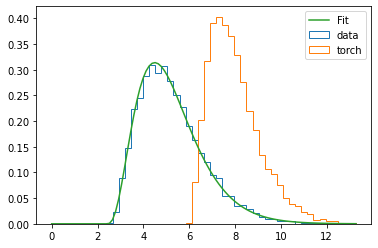

In [131]:
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_2/'
full_gt_df = DF()
for i in range(5):
    img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 2000, 'random', 'NR', i)
    full_gt_df = cat_emitter_dfs([full_gt_df, gt_df])
    
import scipy.stats as stats  

fit_vals = cpu(full_gt_df['int']) 
fit_alpha, fit_loc, fit_beta=stats.gamma.fit(fit_vals)   

dist_samp = cpu(torch.distributions.Gamma(3, 3).sample([10000])+3)*2

_ = plt.hist(fit_vals,bins=np.linspace(0,fit_vals.max(),51),  histtype ='step',label='data', density=True)
_ = plt.hist(dist_samp,bins=np.linspace(0,fit_vals.max(),51),  histtype ='step',label='torch', density=True)
x = np.linspace(0,fit_vals.max(),101)
y = stats.gamma.pdf(x, fit_alpha, fit_loc, fit_beta)
plt.plot(x, y, label='Fit')
plt.legend()

print(f'Fit parameters: shape = {fit_alpha}, scale = {fit_beta}, locaction(offset) = {fit_loc}')

In [7]:
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_2/'
full_gt_df = DF()
for i in range(5):
    img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 2000, 'random', 'NR', i)
    full_gt_df = cat_emitter_dfs([full_gt_df, gt_df])

gt_ints = full_gt_df['int']
gt_ints.mean()

5.230693147590521

In [146]:
cfg = OmegaConf.load(default_conf)

In [147]:
cfg.output.project = 'Fig_sim_density'

cfg.run_name ='fig_sim_m7'
cfg.output.group='psf_opt_runs'

cfg.data_path.image_path = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_foci_fac1_1/mRNAlevel_500/foci/strong/w1*.tif'
cfg.evaluation.txt_path = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_foci_fac1_1/mRNAlevel_500/foci/strong/w1*.txt'
# cfg.data_path.image_path = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_2/mRNAlevel_500/random/NR/w1*.tif'
# cfg.evaluation.txt_path = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_2/mRNAlevel_500/random/NR/w1*.txt'

cfg.evaluation.psf_path ='/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/PSF_subsampled.tif'
cfg.data_path.psf_path = None # '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/PSF_subsampled.tif'
cfg.PSF.psf_extent_zyx = [11,21,21]

cfg.foci.n_foci_avg = 2

cfg.evaluation.crop_sl = 's_[:,:,100:200,100:200]'
cfg.evaluation.px_size_zyx =  [300,100,100]

cfg.PSF.gauss_radii = [1.,1.,1.]
cfg.microscope.scale = 200. # 100 is GT scaling so keep that
cfg.microscope.norm = 'none'

cfg.prob_generator.low = 0.00001
cfg.prob_generator.high = 0.001

cfg.intensity_dist.int_conc = 3.
cfg.intensity_dist.int_rate = 3.
cfg.intensity_dist.int_loc = 3.

cfg.noise.theta = 2.5 * 1.5

In [148]:
OmegaConf.save(cfg, f'../config/experiment/{cfg.run_name}.yaml')

2.529576057133904


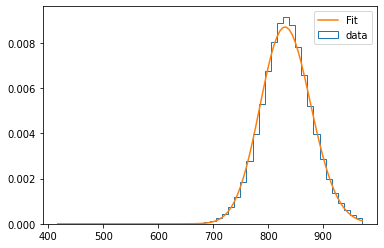

In [135]:
img = load_tiff_image(glob.glob(cfg.data_path.image_path)[0])
bg_est = hydra.utils.instantiate(cfg.bg_estimation.smoothing)(img)
theta = estimate_noise_scale(img, bg_est, percentile=99)
print(theta)

In [136]:
home_dir = os.getenv("HOME")
f'bsub -gpu "num=1" -q gpu_any -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode2_dev/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name}'

'bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=fig_sim_m6'

In [137]:
n_foci = cfg.foci.n_foci_avg
cfg.foci.n_foci_avg = 0
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)
cfg.foci.n_foci_avg = n_foci

20 volumes


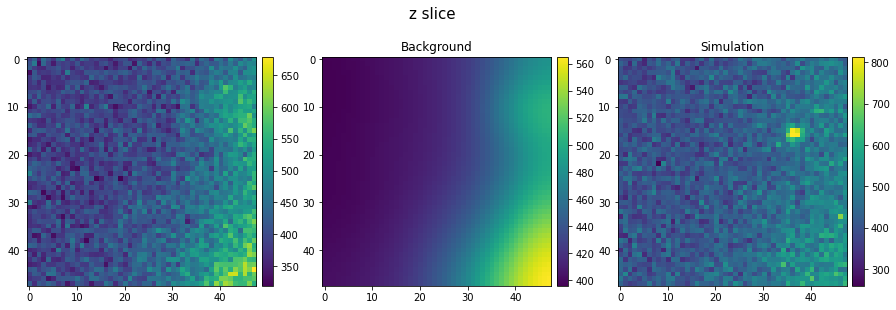

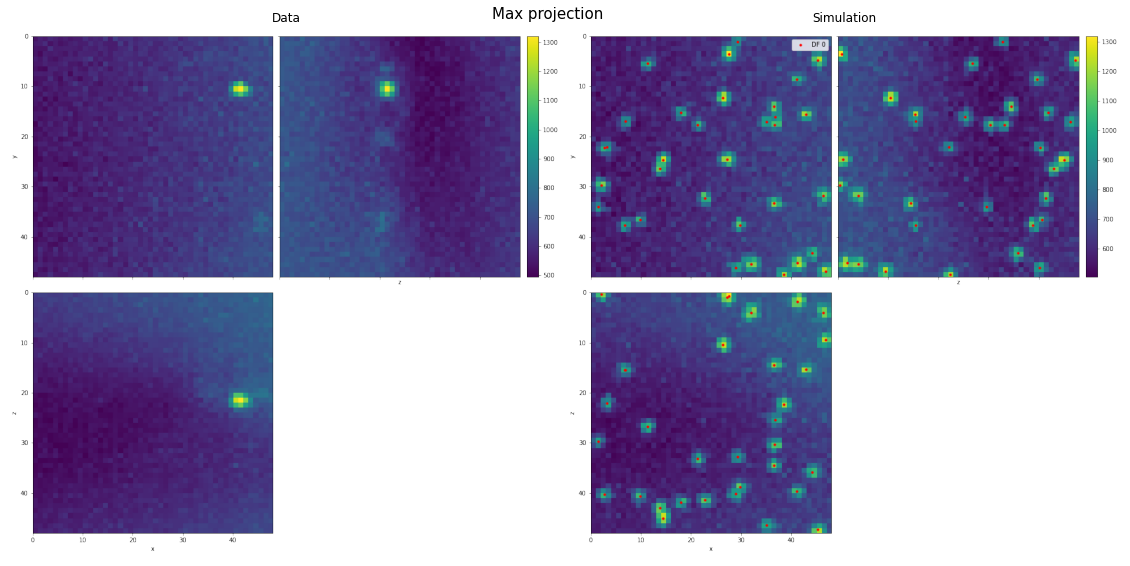

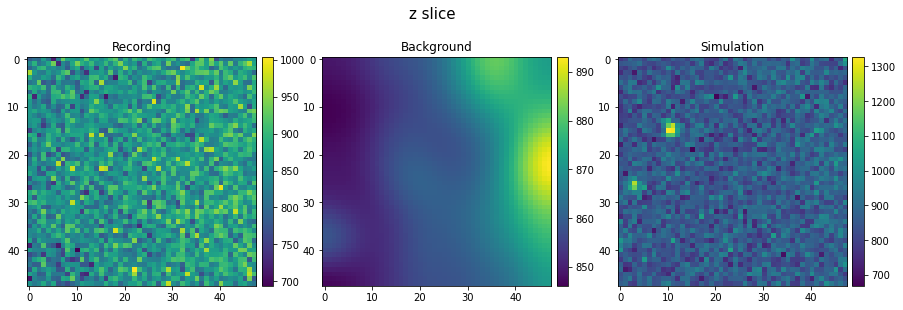

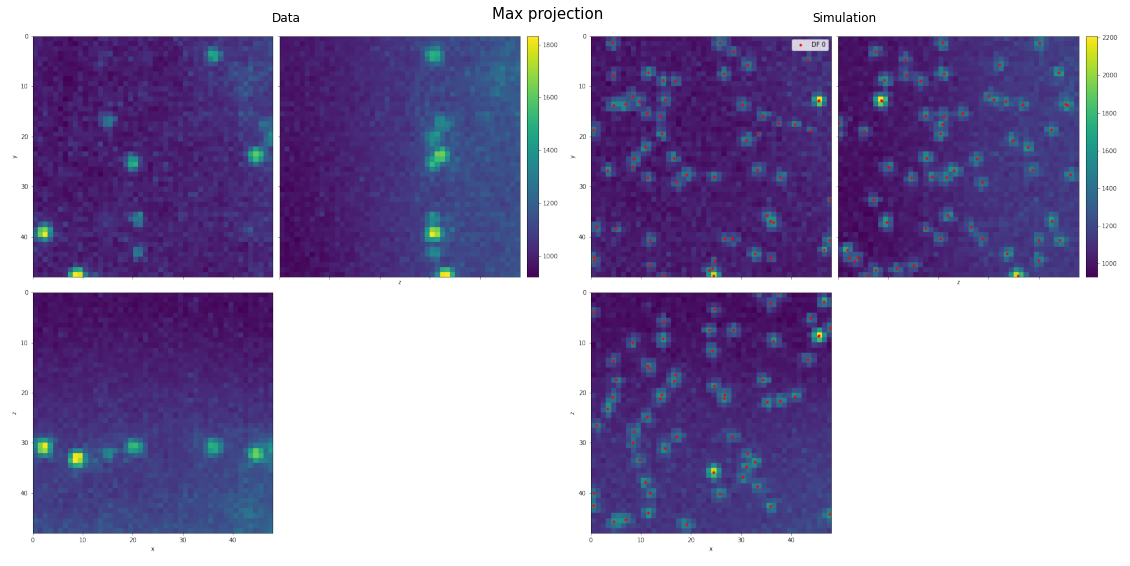

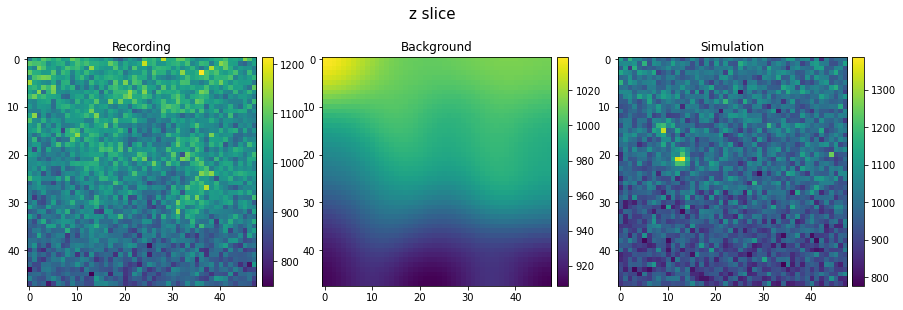

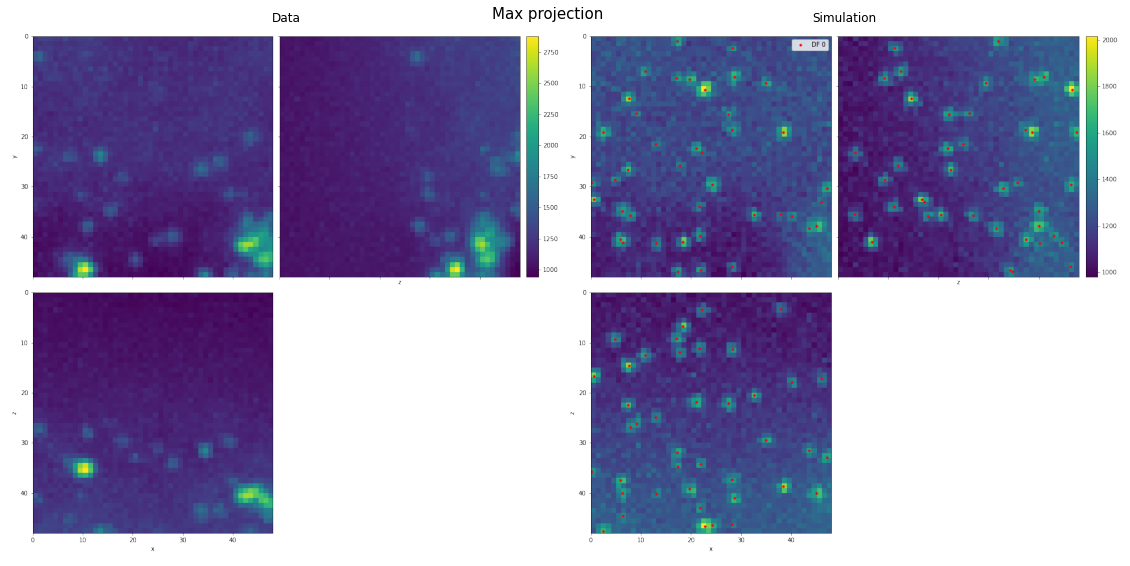

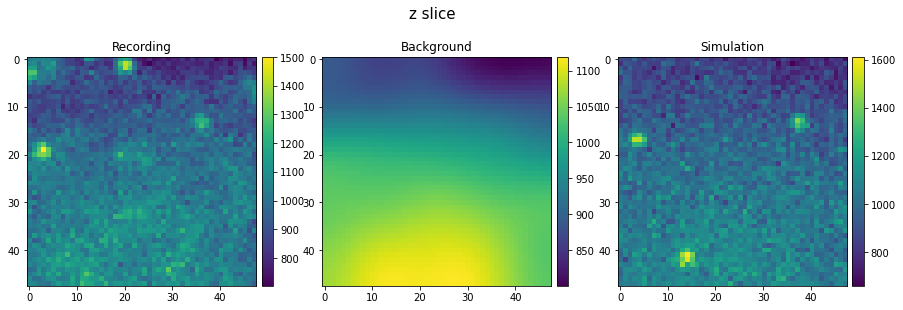

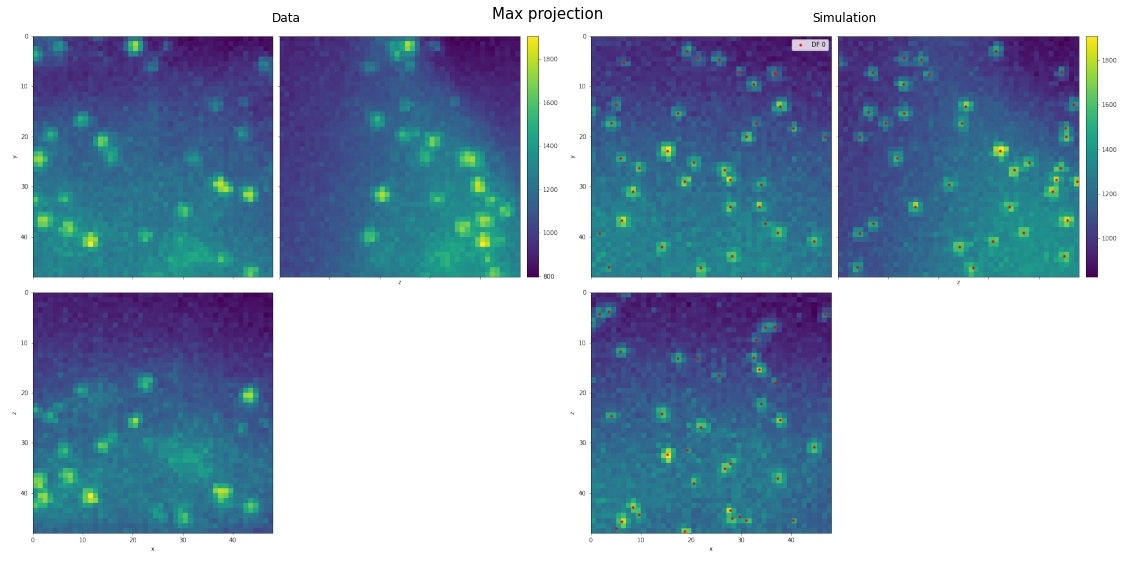

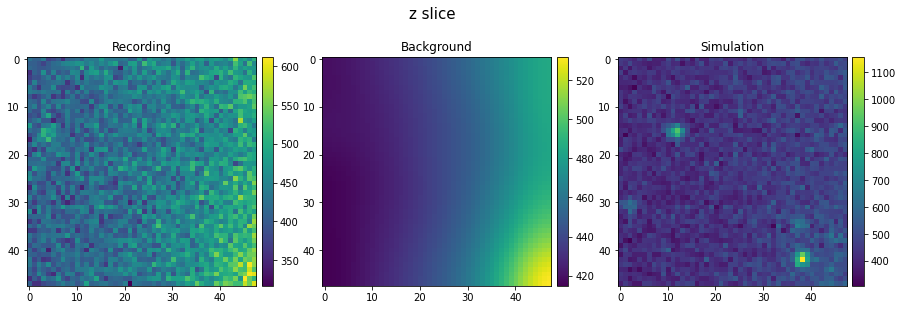

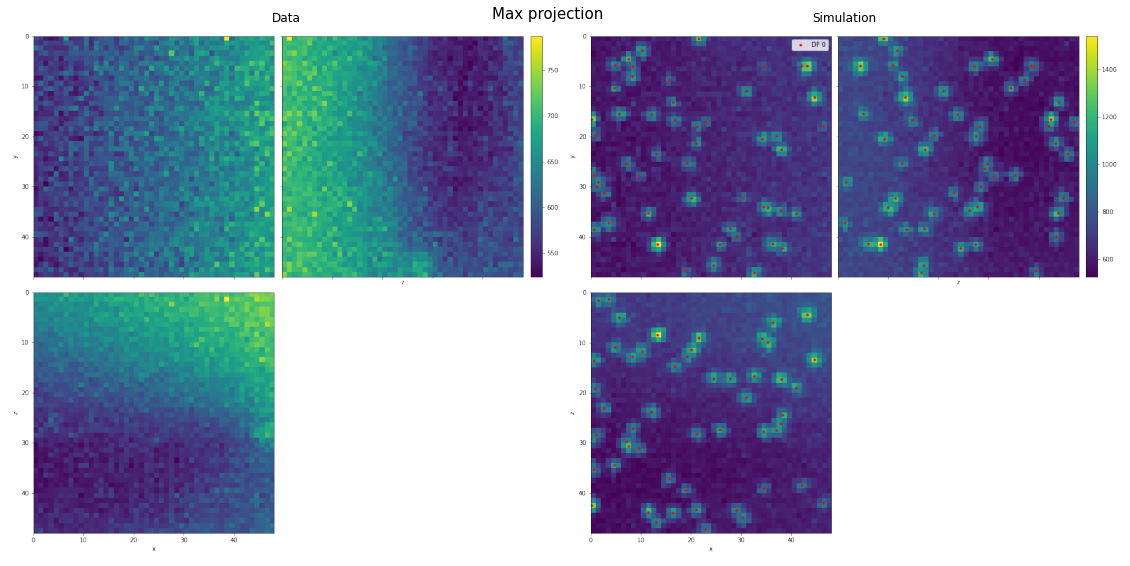

In [138]:
get_simulation_statistics(decode_dl, micro, **cfg.intensity_dist, int_threshold=10, samples=5)

In [108]:
exp = 'nb_run/sim_density_fac1_2'
# exp = 'sweep_f4/int_mu:1.5'
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/{exp}/train.yaml')
# cfg.data_path.image_path = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_1//mRNAlevel_500/random//NR/w1*.tif'

In [109]:
path = Path(cfg.output.save_dir)/'sl_save'
model = hydra.utils.instantiate(cfg.model)
model = load_model_state(model, path, 'model.pkl')
post_proc = hydra.utils.instantiate(cfg.post_proc_isi, samp_threshold=0.5)
psf, noise, micro = load_psf_noise_micro(cfg)
psf.load_state_dict(torch.load(path/'psf.pkl'))
# micro.load_state_dict(torch.load(path/'microscope.pkl'))
psf.cuda()

cfg.dataloader.bs = 1
cfg.foci.n_foci_avg = 0
img_3d, decode_dl = get_dataloader(cfg)

# psf_init, _, micro = load_psf_noise_micro(cfg)b
# psf_init.load_state_dict(torch.load(path/'psf_init.pkl'))
# psf_init.cuda()

TypeError: load_model_state() takes 2 positional arguments but 3 were given

In [ ]:
plot_3d_projections(psf.psf_volume[0])
# plot_3d_projections(psf.psf_volume[0]-psf_init.psf_volume[0], 'mean')
psf.psf_volume[0].sum()

In [251]:
# eval_random_sim(decode_dl, model, post_proc, micro, projection='max', samples=3)

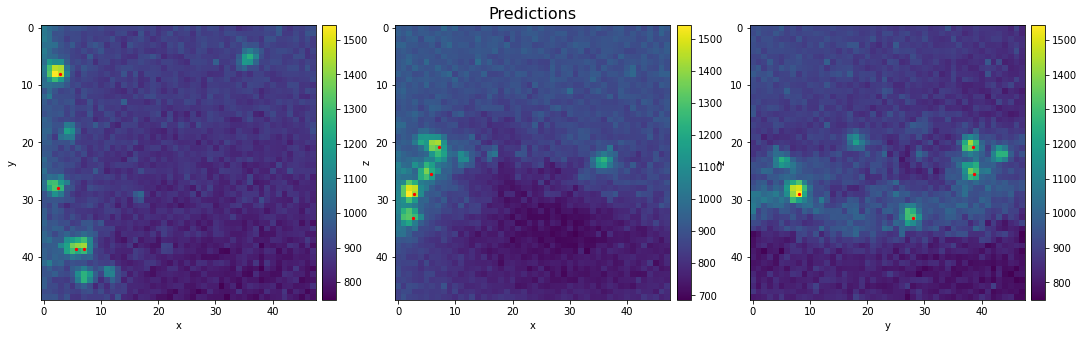

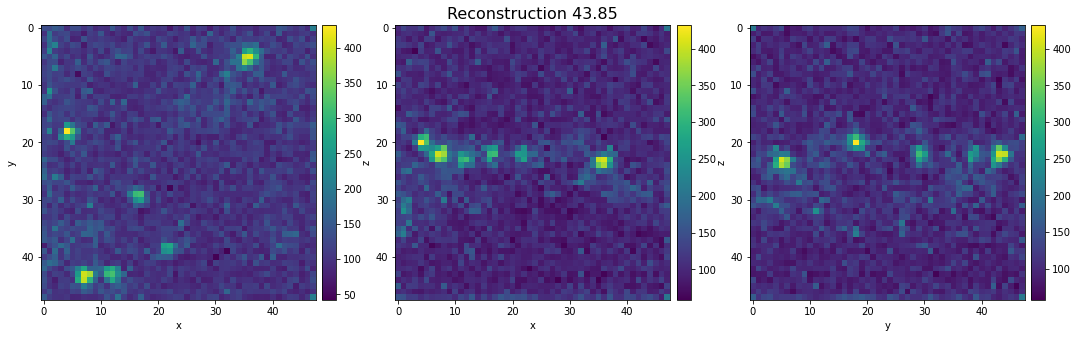

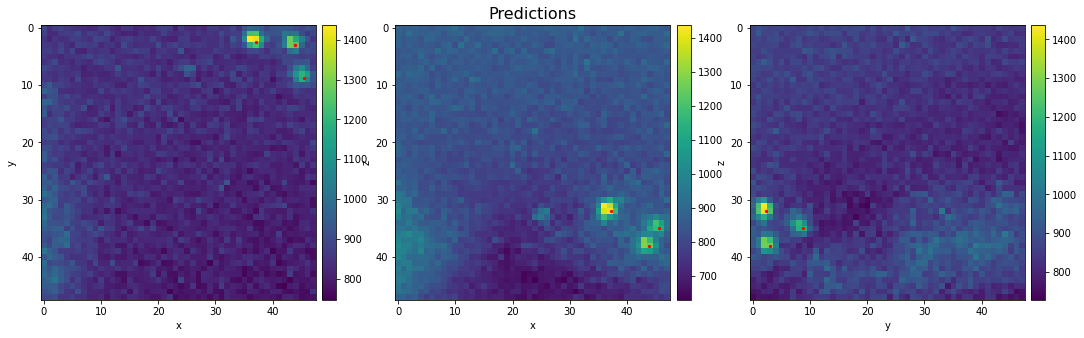

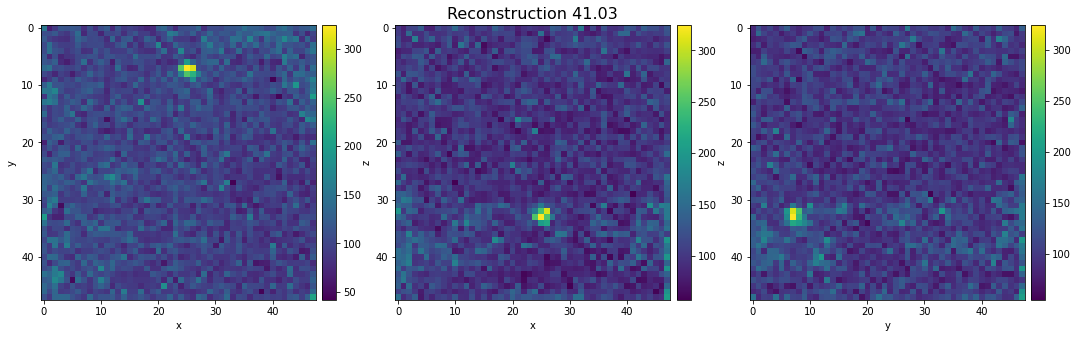

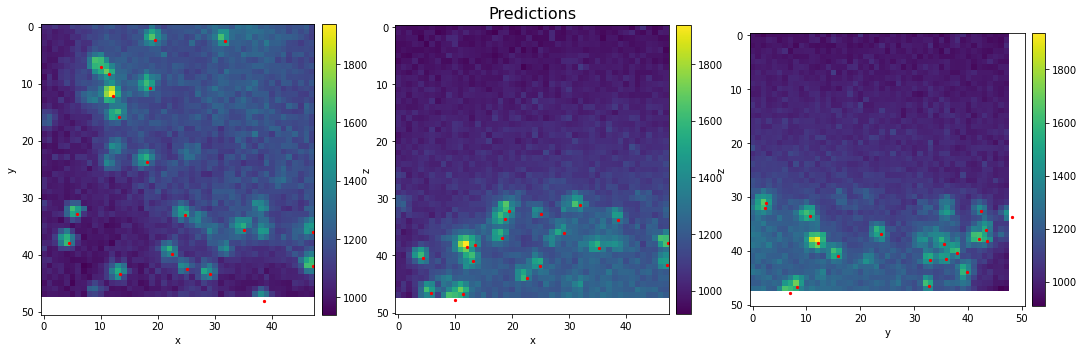

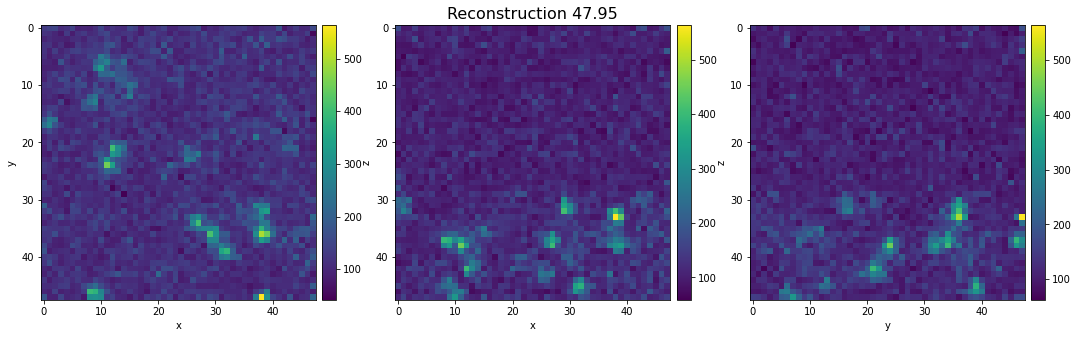

In [252]:
eval_random_crop(decode_dl, model, post_proc, micro, projection='max', samples=3, int_threshold=1000)

In [ ]:
# basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_1//'
# img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 250, 'random', 'NR', 0, shift=[-38, -38, -110])
# model.cuda()
# with torch.no_grad():
#     dec_df = shift_df(post_proc(model(img[None].cuda()), 'df'), [0,0,0])

In [ ]:
# plt.hist(dec_df['int'])

In [ ]:
# sl = np.s_[:,:,150:200,50:100]
# px_preds = nm_to_px(dec_df, px_size=cfg.evaluation.px_size)
# px_gt = nm_to_px(gt_df, px_size=cfg.evaluation.px_size)
# px_preds = crop_df(px_preds, sl)
# px_gt = crop_df(px_gt, sl)

# px_preds = px_preds[px_preds['int'] > 0.3]

# axes = plot_3d_projections(img[0][sl[1:]], 'max')

# axes[0].scatter(px_preds['x'],px_preds['y'], color='red', s=5.)
# axes[1].scatter(px_preds['x'],px_preds['z'], color='red', s=5.)
# axes[2].scatter(px_preds['y'],px_preds['z'], color='red', s=5.)

# axes[0].scatter(px_gt['x'],px_gt['y'], color='black', s=5., marker='+')
# axes[1].scatter(px_gt['x'],px_gt['z'], color='black', s=5., marker='+')
# axes[2].scatter(px_gt['y'],px_gt['z'], color='black', s=5., marker='+')

In [235]:
# model,post_proc,cfg = get_model_pp_cfg('/nb_run/sim_density_fac1_3')
# img_3d, decode_dl = get_dataloader(cfg)
# _ = model.cuda()

20 volumes


array([<AxesSubplot:xlabel='x', ylabel='y'>,
       <AxesSubplot:xlabel='x', ylabel='z'>,
       <AxesSubplot:xlabel='y', ylabel='z'>], dtype=object)

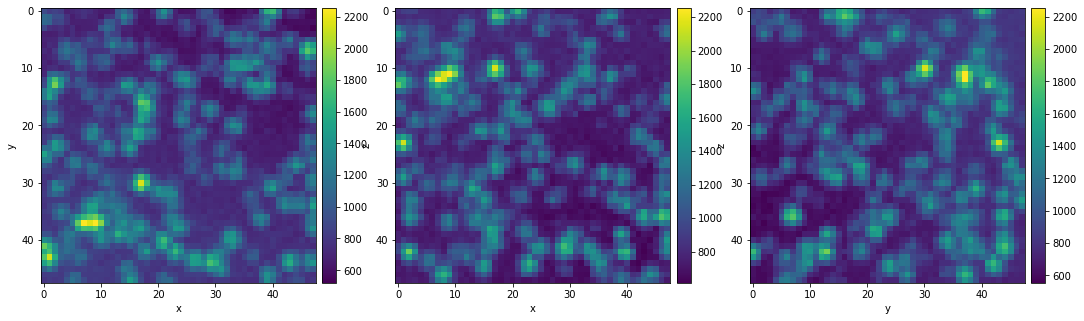

In [236]:
plot_3d_projections(xsim[0,0], 'max')

In [242]:
def sim_data(decode_dl, batches):
    
    gt_dfs = []
    xsim_col = []
    
    for _ in range(batches):
        x, local_rate, background = next(iter(decode_dl))
        sim_vars = PointProcessUniform(local_rate).sample()
        xsim = micro(*sim_vars)
        x = micro.noise(xsim, background).sample()
        
        xsim_col.append(x)
        gt_vars = filt_sim_vars(*sim_vars[:-1], micro.int_mu, micro.int_sig, micro.min_fac)
        gt_dfs.append(sample_to_df(*gt_vars, px_size=[1.,1.,1.]))
        
    return torch.cat(xsim_col), cat_emitter_dfs(gt_dfs)

def get_sim_perf(x, gt_df, model, post_proc, micro, cuda=True, print_res=True):

    pred_dfs = []
    x_recs = []
    
    for i in range(len(x)):
        
        pred_df, rec, res_dict = get_prediction(model, post_proc, x[i:i+1], micro=micro, cuda=True, return_rec=True, min_int=-100)
        pred_dfs.append(pred_df)
        x_recs.append(rec)
        
    pred_df = cat_emitter_dfs(pred_dfs)
    xrec = torch.cat(x_recs)
    perf, matches, _ = matching(gt_df, pred_df, tolerance=500, print_res=print_res)
    perf['mae'] = abs(xrec-rec).mean().item()
    perf['rmse'] = torch.sqrt(((xrec-rec)**2).mean()).item()
    
    return perf, pred_df, matches

Recall: 0.940
Precision: 0.990
Jaccard: 93.135
RMSE_vol: 36.199
Eff_3d: 80.642
FN: 85.0 FP: 14.0
Shift: -0.16,-0.17,10.77


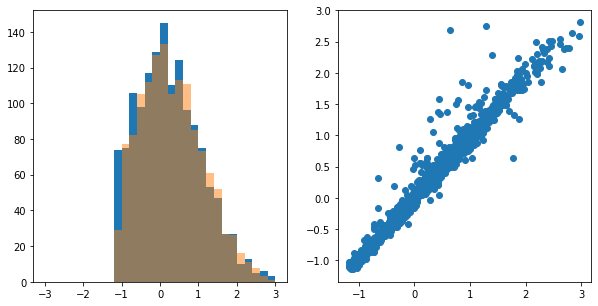

In [246]:
xsim, gt = sim_data(decode_dl, 10)
perf, pred_df, matches = get_sim_perf(xsim, px_to_nm(gt, cfg.evaluation.px_size), model, post_proc, micro, print_res=True)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(gt['int'], bins=np.linspace(-3,3,31))
plt.hist(pred_df['int'],alpha=0.5, bins=np.linspace(-3,3,31))
plt.subplot(122)
plt.scatter(matches['int_tar'],matches['int_pred'])

In [ ]:
model,post_proc,cfg = get_model_pp_cfg('nb_run/sim_density_fac1_2')
model,post_proc,cfg = get_model_pp_cfg('sweep_f4/int_')

In [247]:
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_1//'
densities = [250,500,1000,2000,4000]
n_cells = 5

model.cuda()

dec_col = []

comb_perc = 100

dec_df = []
gtc_df = []
for i in range(n_cells):
    img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 500, 'random', 'NR', i)
    gtc_df.append(gt_df)
    with torch.no_grad():
        curr_df = shift_df(post_proc(model(img[None].cuda()), 'df'), [-100,-100,-100])
        curr_df = sig_filt(curr_df, comb_perc)
        dec_df.append(shift_df(curr_df, [0,0,0]))
        
gtc_df = cat_emitter_dfs(gtc_df)
dec_df = cat_emitter_dfs(dec_df)
perf_df, matches, shift = matching(gtc_df, dec_df, print_res=True)

# # Run over all densities

for d in densities:
    print(d)
    gtc_df = []
    dec_df = []
    for i in range(n_cells):
        img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, d, 'random', 'NR', i)
        gtc_df.append(gt_df)
        with torch.no_grad():
            curr_df = shift_df(post_proc(model(img[None].cuda()), 'df'), [-100,-100,-100])
            curr_df = sig_filt(curr_df, comb_perc)
            dec_df.append(shift_df(curr_df, shift))
        
    gtc_df = cat_emitter_dfs(gtc_df)
    dec_df = cat_emitter_dfs(dec_df)
            
    perf_df, matches, _ = matching(gtc_df, dec_df, print_res=True)
    dec_col.append(perf_df)

Recall: 0.994
Precision: 0.321
Jaccard: 32.050
RMSE_vol: 156.545
Eff_3d: -3.652
FN: 16.0 FP: 5473.0
Shift: 19.07,13.89,-133.10
250
Recall: 0.993
Precision: 0.252
Jaccard: 25.177
RMSE_vol: 53.160
Eff_3d: 20.596
FN: 9.0 FP: 4006.0
Shift: -3.01,1.65,-22.84
500
Recall: 0.993
Precision: 0.321
Jaccard: 32.017
RMSE_vol: 63.478
Eff_3d: 24.973
FN: 18.0 FP: 5475.0
Shift: -2.12,0.25,-17.89
1000


KeyboardInterrupt: 

(array([3399., 1173., 2929., 2370., 1308.,  592.,  209.,   79.,   30.,
           8.]),
 array([-1.2601471 , -0.83288234, -0.40561756,  0.02164719,  0.44891196,
         0.8761767 ,  1.3034415 ,  1.7307062 ,  2.157971  ,  2.5852358 ,
         3.0125005 ], dtype=float32),
 <BarContainer object of 10 artists>)

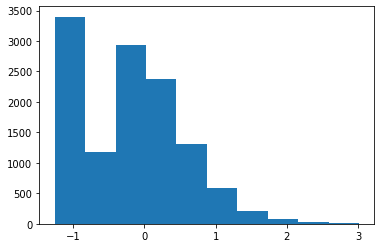

In [248]:
plt.hist(dec_df['int'])

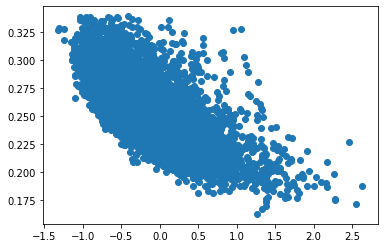

In [165]:
plt.scatter(dec_df['int'], dec_df['comb_sig'])

In [ ]:
free_mem()

In [ ]:
Recall: 0.865
Precision: 0.986
Jaccard: 85.470
RMSE_vol: 174.918
Eff_3d: 11.342
FN: 352.0 FP: 31.0
Shift: 14.98,15.96,-166.25
250
Recall: 0.879
Precision: 0.988
Jaccard: 86.982
RMSE_vol: 38.392
Eff_3d: 76.806
FN: 164.0 FP: 15.0
Shift: 0.55,-0.23,-5.82
500
Recall: 0.865
Precision: 0.986
Jaccard: 85.470
RMSE_vol: 41.595
Eff_3d: 74.630
FN: 352.0 FP: 31.0
Shift: -0.63,0.27,-4.34
1000

In [ ]:
with open(basedir + 'dec1_perf_dfs.pkl', 'wb') as f:
    pickle.dump({'dec':dec_col, 'densities':[250,500,1000,2000,4000]}, f)

In [ ]:
base_str = 'bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/operf.log -e /groups/turaga/home/speisera/logs/eperf.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/get_perf.py '
#        exp                 datadir           #int #resname
evals = ['sim_density_fac2_2 sim_density_fac2_1 0.3 2',
         'sim_density_fac1_2 sim_density_fac1_1 0.0 2',
         'sim_density_fac05_2 sim_density_fac05_1 0.0 2']

with open('run_slurm.sh', 'w') as f: 
    for s in evals:
        exec_str = base_str + s +  '\n'
        print(exec_str)
        f.write(exec_str)

In [187]:
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_foci_fac1_1///'
n_cells = 20

model.cuda()

dec_col = []

dec_df = []
gtc_df = []
for i in range(5):
    img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 100, 'foci', 'strong', i)
    gtc_df.append(gt_df)
    with torch.no_grad():
        curr_df = shift_df(post_proc(model(img[None].cuda()), 'df'), [-100,-100,-100])
        dec_df.append(shift_df(curr_df, [0,0,0]))
        
gtc_df = cat_emitter_dfs(gtc_df)
dec_df = cat_emitter_dfs(dec_df)
perf_df, matches, shift = matching(gtc_df, dec_df, print_res=True)


gtc_df = []
dec_df = []
for i in range(n_cells):
    img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 100, 'foci', 'strong', i)
    gtc_df.append(gt_df)
    with torch.no_grad():
        curr_df = shift_df(post_proc(model(img[None].cuda()), 'df'), [-100,-100,-100])
        dec_df.append(shift_df(curr_df, shift))

gtc_df = cat_emitter_dfs(gtc_df)
dec_df = cat_emitter_dfs(dec_df)


perf_df, matches, _ = matching(gtc_df, dec_df, print_res=True)
dec_col.append(perf_df)

Recall: 0.875
Precision: 0.475
Jaccard: 44.507
RMSE_vol: 174.666
Eff_3d: -3.472
FN: 79.0 FP: 608.0
Shift: 10.17,7.60,-111.95
Recall: 0.896
Precision: 0.549
Jaccard: 51.590
RMSE_vol: 105.366
Eff_3d: 28.453
FN: 299.0 FP: 2106.0
Shift: 2.94,3.27,-34.85


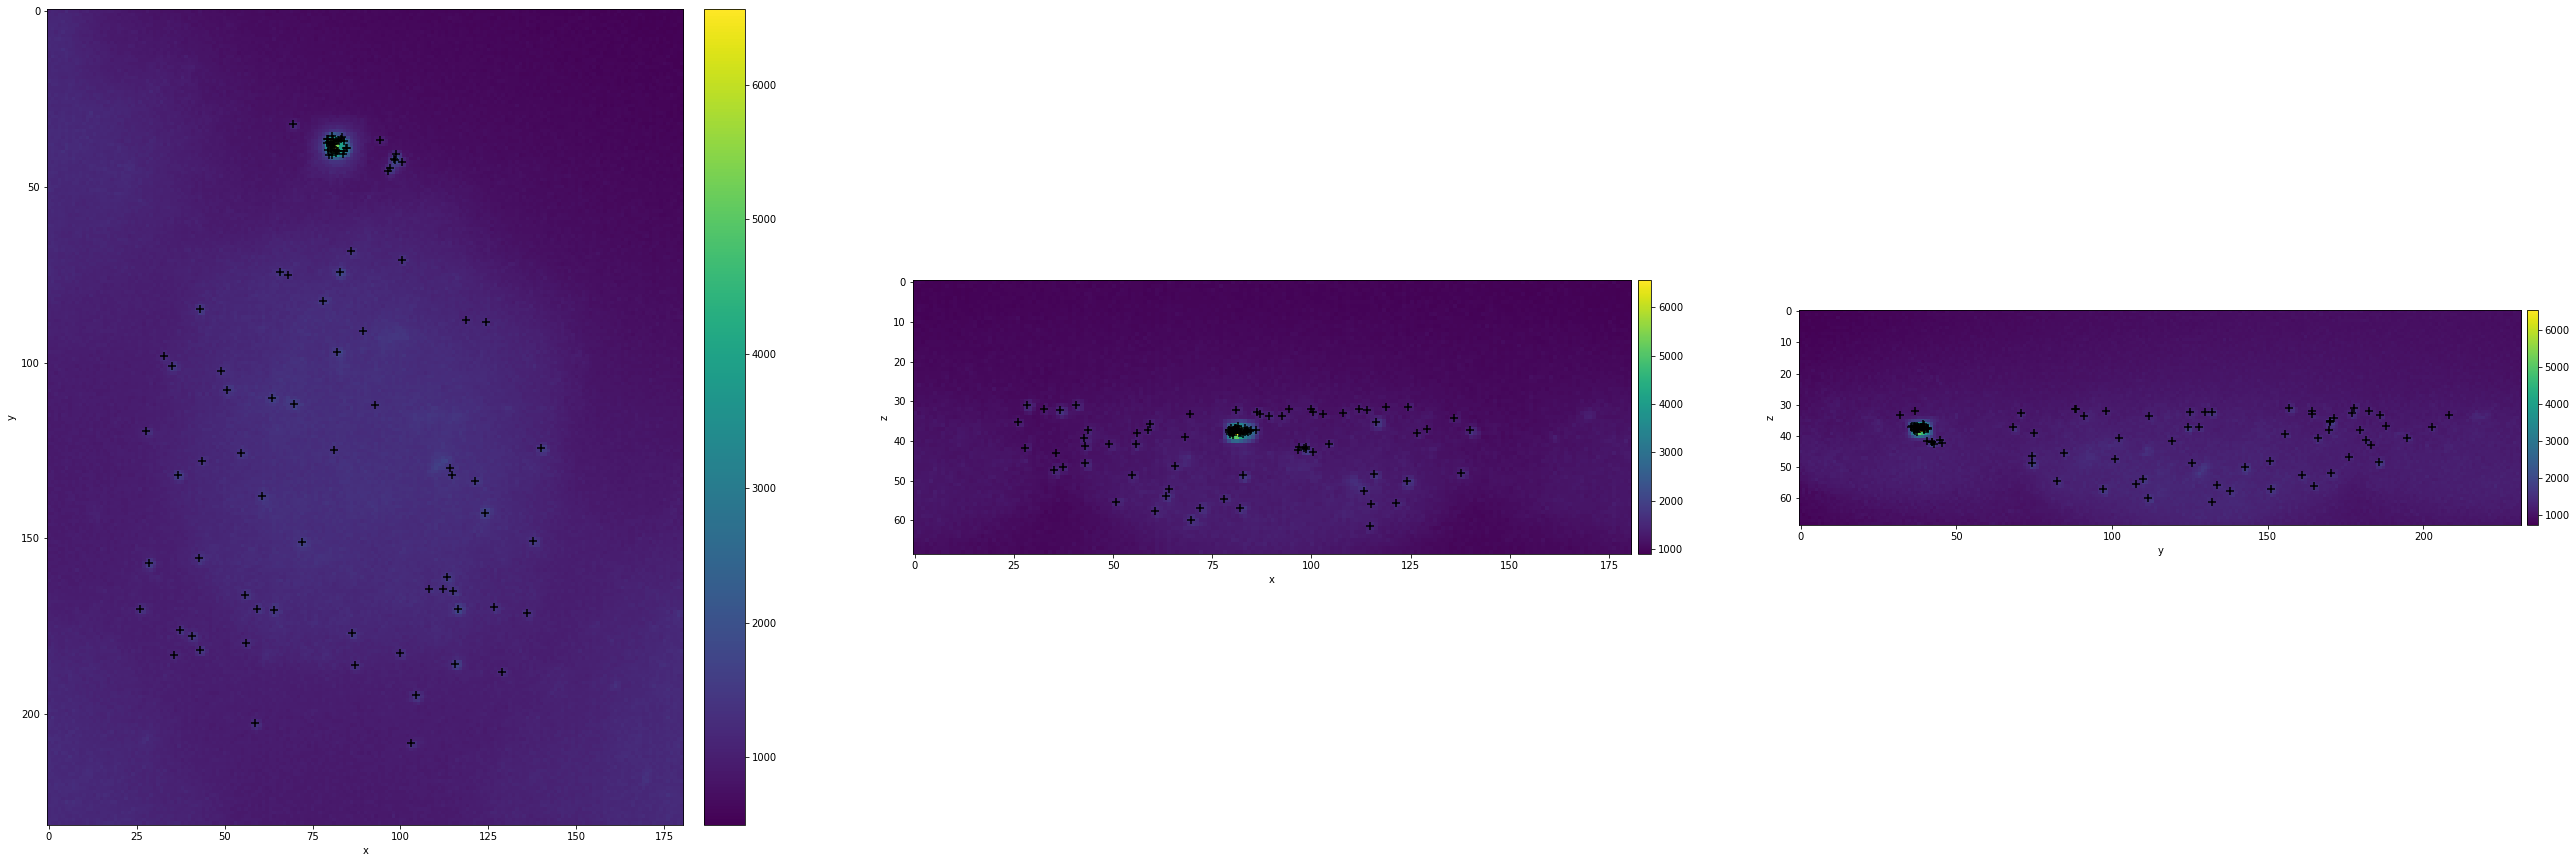

In [253]:
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_foci_fac1_1//'
ind = 5
img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 100, 'foci', 'strong', ind)
axes = plot_3d_projections(img[0], 'max', size=15)
sub_df = dec_df[dec_df['frame_idx'] == ind]

gt_px = nm_to_px(gt_df, px_size=[100,100,300])
dec_px = nm_to_px(sub_df, px_size=[100,100,300])
axes[0].scatter(gt_px['x'],gt_px['y'], color='black', marker='+', s=50.)
axes[1].scatter(gt_px['x'],gt_px['z'], color='black', marker='+', s=50.)
axes[2].scatter(gt_px['y'],gt_px['z'], color='black', marker='+', s=50.)

axes[0].scatter(dec_px['x'],dec_px['y'], color='red', s=5.)
axes[1].scatter(dec_px['x'],dec_px['z'], color='red', s=5.)
axes[2].scatter(dec_px['y'],dec_px['z'], color='red', s=5.)

# perf_df, matches, _ = matching(gt_df, sub_df, print_res=True)

In [ ]:
from decode_fish.funcs.fit_psf import get_peaks_3d
from decode_fish.funcs.fit_psf import plot_detection

In [ ]:
model,post_proc,cfg = get_model_pp_cfg('nb_run/sim_density_fac1_2')
_ = model.cpu()

In [ ]:
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_foci_fac1_1//'

mults = [2.,2.5,3.,3.5,4.]

dec_count_col = []
prob_sum_col = []

for m in mults:
        
    model,post_proc,cfg = get_model_pp_cfg(f'sweep_f1/multipl:{str(m)}/')
    _ = model.cuda()

    box_sz = 10
    n_cells = 20
    gt_counts = []
    fq_counts = []
    dec_counts = []
    prob_sums = []

    for i in tqdm(range(n_cells)):

        img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 100, 'foci', 'strong', i)
        gt_px = nm_to_px(gt_df, px_size=[100,100,300])
        fq_px = nm_to_px(fq_gmm_df, px_size=[100,100,300])
        with torch.no_grad():
            res_dict = model(img[None].cuda())
            dec_df = shift_df(post_proc(res_dict, 'df'), [-100,-100,-100])
            free_mem()
        dec_px = nm_to_px(dec_df, px_size=[100,100,300])

        try:
            coords_xyz = get_peaks_3d(img[0], threshold=2000, min_distance=10)
        except AssertionError:
            continue
        coords_zyx = coords_xyz[:,::-1]

        for c in coords_zyx:
            sl = np.s_[:,c[0]-box_sz:c[0]+box_sz+1, c[1]-box_sz:c[1]+box_sz+1, c[2]-box_sz:c[2]+box_sz+1]
            gt_crop = crop_df(gt_px, sl)
            fq_crop = crop_df(fq_px, sl)
            dec_crop = crop_df(dec_px, sl)
            prob_crop = torch.sigmoid(res_dict['logits'])[0][sl]

            gt_counts.append(len(gt_crop))
            fq_counts.append(len(fq_crop))
            dec_counts.append(len(dec_crop))
            prob_sums.append(prob_crop.sum().item())
            
    dec_count_col.append(dec_counts)
    prob_sum_col.append(prob_sums)

In [ ]:
plt.figure(figsize=(10,10))
import seaborn as sns
plt.scatter(gt_counts, fq_counts, label='FISH-quant')
for i,c in enumerate(prob_sum_col):
    plt.scatter(gt_counts, c, label=f'DEC {mults[i]} counts')
    

# plt.scatter(gt_counts, prob_sums, label='DEC probs')

plt.plot([0,100],[0,100], 'red')
plt.xlabel('Ground truth N mRNA')
plt.ylabel('Predicted N mRNA')
plt.legend()
sns.despine()
# print('Corr. FQ: ', np.corrcoef([gt_counts, fq_counts])[0,1])
# print('Corr. DECODE: ', np.corrcoef([gt_counts, dec_counts])[0,1])

In [ ]:
plt.scatter(gt_counts, fq_counts, label='FISH-quant')
plt.scatter(gt_counts, dec_counts, label='DEC counts')
plt.scatter(gt_counts, prob_sums, label='DEC probs')

plt.plot([0,100],[0,100], 'red')
plt.xlabel('Ground truth N mRNA')
plt.ylabel('Predicted N mRNA')
plt.legend()
print('Corr. FQ: ', np.corrcoef([gt_counts, fq_counts])[0,1])
print('Corr. DECODE: ', np.corrcoef([gt_counts, dec_counts])[0,1])

In [ ]:
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_foci_fac1_1//'
model,post_proc,cfg = get_model_pp_cfg(f'nb_run/sim_density_fac1_3/')
_ = model.cuda()

box_sz = 10
n_cells = 20
gt_counts = []
fq_counts = []
dec_counts = []
prob_sums = []

for i in tqdm(range(n_cells)):

    img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 100, 'foci', 'strong', i)
    gt_px = nm_to_px(gt_df, px_size=[100,100,300])
    fq_px = nm_to_px(fq_gmm_df, px_size=[100,100,300])
    with torch.no_grad():
        res_dict = model(img[None].cuda())
        dec_df = shift_df(post_proc(res_dict, 'df'), [-100,-100,-100])
        free_mem()
    dec_px = nm_to_px(dec_df, px_size=[100,100,300])

    try:
        coords_xyz = get_peaks_3d(img[0], threshold=2000, min_distance=10)
    except AssertionError:
        continue
    coords_zyx = coords_xyz[:,::-1]

    for c in coords_zyx:
        sl = np.s_[:,c[0]-box_sz:c[0]+box_sz+1, c[1]-box_sz:c[1]+box_sz+1, c[2]-box_sz:c[2]+box_sz+1]
        gt_crop = crop_df(gt_px, sl)
        fq_crop = crop_df(fq_px, sl)
        dec_crop = crop_df(dec_px, sl)
        prob_crop = torch.sigmoid(res_dict['logits'])[0][sl]

        gt_counts.append(len(gt_crop))
        fq_counts.append(len(fq_crop))
        dec_counts.append(len(dec_crop))
        prob_sums.append(prob_crop.sum().item())

In [ ]:
plt.scatter(gt_counts, fq_counts, label='FISH-quant')
plt.scatter(gt_counts, dec_counts, label='DEC counts')
plt.scatter(gt_counts, prob_sums, label='DEC probs')

plt.plot([0,100],[0,100], 'red')
plt.xlabel('Ground truth N mRNA')
plt.ylabel('Predicted N mRNA')
plt.legend()
print('Corr. FQ: ', np.corrcoef([gt_counts, fq_counts])[0,1])
print('Corr. DECODE: ', np.corrcoef([gt_counts, dec_counts])[0,1])

In [ ]:
basedir

In [ ]:
free_mem()